# Contributing to stdpopsim
In this workshop we are going to go through the major routes by which one can add to the `stdpopsim` catalog specifically, but to a lesser extent along the way we will highlight the myriad additions and contributions that we'd love to see the community build on to the project. 

By way of a road map, through this workshop we will look at 1) how to add a new species genome to the `stdpopsim` catalog, using the mosquito _Anopheles gambiae_ as our example, 2) adding a genetic map to our genome, and 3) adding a demographic model to our new species or any other that already exists in the catalog. 

## Getting ready to develop with us on github
[Github](https://github.com) provides an incredibly powerful tool for us to collaboratively build code on. Their platform enables everything from automated testing, to code review tools, to excellent version control. As we step through the workshop, at various turns we will depend on Github and its commandline engine `git`. 

### Create your own fork of stdpopsim
Okay the first step towards contributing to `stdpopsim` is to create your own _fork_ on github. Do to that
navigate to [the popsim-consortium github repo](https://github.com/popsim-consortium/stdpopsim) and hit the `fork` button on the top right (see Figure 1 below). 
![Figure 1. Fork our repo on Github](gh1.png)

### Clone your fork locally
Next clone your now up-to-date fork locally on to your machine. This can be done at the commandline using `git` as
```
git clone https://github.com/<your_username>/stdpopsim.git
```
with your actual github username in place of `<your_username>`.

### Setup a python environment to code in
Next (and for the sake of completeness) I'm going to start by setting up a new `conda` virtual environment and then will install the `stdpopsim` development requirements onto that using `pip`. Further documentation on installation of `stdposim` can be found [here](https://stdpopsim.readthedocs.io/en/latest/development.html#installation).
```
cd stdpopsim
conda create -n stdpopsim python=3.9 --yes
conda activate stdpopsim
pip install -r requirements/development.txt
```
with that done everything should be in place for us to start coding!

finally as a last step I will setup the automated code checking / error correction that we use by running 
```
pre-commit install
```

## Adding a species
For the sake of the workshop we are going to go through all of the steps that it would take to add a species, in this case _Anopheles gambiae_. Again our workflow actually starts with considerations of `git` and version control. Our first step will be to create a new _branch_ of `stdpopsim` using `git` which will effectively keep track of the new features we will be adding

```
git checkout -b mosquito
```
now any changes that I commit, will only be committed to the branch called `mosquito`. 

`stdpopsim` has a few utilities that play well with [Ensembl](https://ensembl.org/index.html), including one that we will use to create some code templates for us to buildout a new species. This utility lives on the "maintenance" side of `stdpopsim` which houses utilities that are not user facing. 

To add our species we will hand the `maintenance` command line interface an Ensembl species ID and it will go and pull down some essential information about the genome. A partial list of the genomes housed on Ensembl [can be found here](https://metazoa.ensembl.org/species.html)
```
python -m maintenance add-species Anopheles_gambiae
```
and it returns to me
```
2021-03-10 12:30:59,590 [3668] INFO     maint: Adding new species AnoGam for Ensembl ID anopheles_gambiae
2021-03-10 12:30:59,590 [3668] INFO     maint: Writing genome data for AnoGam anopheles_gambiae
2021-03-10 12:30:59,591 [3668] INFO     ensembl: making request to http://rest.ensembl.org/info/assembly/anopheles_gambiae?synonyms=1
2021-03-10 12:31:00,468 [3668] INFO     ensembl: making request to http://rest.ensembl.org/info/genomes/anopheles_gambiae
2021-03-10 12:31:02,846 [3668] INFO     maint: AnoGam: name=Anopheles gambiae, common_name=Anopheles gambiae
2021-03-10 12:31:02,846 [3668] INFO     maint: Writing species definition stub to stdpopsim/catalog/AnoGam/species.py
2021-03-10 12:31:02,904 [3668] INFO     maint: Writing species test stub to tests/test_AnoGam.py
2021-03-10 12:31:02,938 [3668] INFO     ensembl: making request to http://rest.ensembl.org/info/data
2021-03-10 12:31:03,853 [3668] INFO     maint: Using Ensembl release 103
```
wicked. The next steps are going to be to flesh out the code templates that the `maintenance` code just wrote for us in our branch. Let's go look at the files that were just created for us and we will compare them to a closely related genome. 

### Looking at the catalog

The function call above has created a few new files in the directory structure of stdpopsim, in particular at the level of `stdpopsim/catalog` this utility has created a new directory called `AnoGam`, which contains three files. The 3 + 3 naming scheme for this directory (and all following references in `stdpopsim`) is automatically parsed by the maintenance script.
```
├── catalog
│   ├── AnoGam
│   │   ├── __init__.py
│   │   ├── genome_data.py
│   │   └── species.py
```



first lets look in `genome_data.py` file. this contains the **physical map** of the genome. 

In [83]:
! cat ../../stdpopsim/stdpopsim/catalog/AnoGam/genome_data.py

# File autogenerated from Ensembl REST API. Do not edit.
data = {
    "assembly_accession": "GCA_000005575.1",
    "assembly_name": "AgamP4",
    "chromosomes": {
        "2L": {"length": 49364325, "synonyms": []},
        "2R": {"length": 61545105, "synonyms": []},
        "3L": {"length": 41963435, "synonyms": []},
        "3R": {"length": 53200684, "synonyms": []},
        "X": {"length": 24393108, "synonyms": []},
        "Mt": {"length": 15363, "synonyms": []},
    },
}


we can see that the utility has sucked down a whole lot of useful information for us for free. this `genome_data.py` essentially puts together a data dictionary which has slots for the assembly accession number, the assembly name, and a dict representing the chromosome names and their associated lengths. If synonyns are defined (e.g., chr2L for 2L) then those are given in the list that follows. There is no reason to edit this file-- we are good here. 

Next let's look at the `species.py` file. This is the file that we will need to edit with our species specific information. The basics that we will need here include:
- a genome-wide average recombination rate
- a genome-wide average mutation rate
- a generate time estimate (in years)
- a default population size
- literature citations that one can point to for the above and the assembly

in addition there is some optional information that we might add. this could include chromosome specific recombination
or mutation rates, but we will keep things simple for the most part today.

### Recombination Rates
As a reference for recombination rates in my organism I'm going to use a mapping based study from [Pombi et al. (2006)](https://doi.org/10.4269/ajtmh.2006.75.901).
In that manuscript the authors cite rates around 1cM/Mb, with a bit of variation among arms. In particular let's edit the following block of code in `species.py` that defines the recombination_rate dict

In [ ]:
_recombination_rate = {
    "2L": 0, #setting to zero because of inversion 
    "2R": 1.3e-8, 
    "3L": 1.6e-8, 
    "3R": 1.3e-8, 
    "X": 1e-8,
    "Mt": 0
}

next we need to add a citation for these rates. will we do that by adding a `stdpopsim.Citation` object to the file that we will include later. that Citation object looks like this

In [ ]:
_PombiEtAl = stdpopsim.Citation(
    doi="https://doi.org/10.4269/ajtmh.2006.75.901",
    year=2006,
    author="Pombi et al.",
    reasons={stdpopsim.CiteReason.REC_RATE},
)

### Mutation rates
okay having edited our file that takes care of recombination rate defaults and citations. Next we need to add mutation rates. As it turns out we don't have great estimates for mutation rate in Anopheles but in a recent population genomics effort by the [Ag1000G consortium](https://doi.org/10.1038/nature24995) we have relied on Drosophila estimates from [Schrider et al. (2013)](https://doi.org/10.1534/genetics.113.151670) that set $u=5.49e^{-9}$. We'll go with that. 

So again first let's add a citation for the mutation rate and then edit the `_mutation_rate` dict that was templated for us

In [ ]:
_Ag1000G = stdpopsim.Citation(
    doi="https://doi.org/10.1038/nature24995",
    year=2017,
    author="Ag1000G Consortium",
    reasons={stdpopsim.CiteReason.MUT_RATE, stdpopsim.CiteReason.GEN_TIME, stdpopsim.CiteReason.POP_SIZE},
)

and for the mutation rate block let's set an overall rate as suggested and then populate our dict

In [ ]:
_overall_rate = 5.49e-9
_mutation_rate = {
    "2L": _overall_rate,
    "2R": _overall_rate,
    "3L": _overall_rate,
    "3R": _overall_rate,
    "X": _overall_rate,
    "Mt": _overall_rate
}

I still need an assembly citation. Ensembl points me to this publication for
their current assembly by [Sharakhova et al. (2006)](https://doi.org/10.1186/gb-2007-8-1-r5). I'll create a citation for that and then edit

In [ ]:
_SharakhovaEtAl = stdpopsim.Citation(
    doi="https://doi.org/10.1186/gb-2007-8-1-r5",
    year=2006,
    author="Sharakhova et al.",
    reasons={stdpopsim.CiteReason.ASSEMBLY},
)

and now we will put it all together to create the genome object

In [ ]:
_genome = stdpopsim.Genome.from_data(
    genome_data.data,
    recombination_rate=_recombination_rate,
    mutation_rate=_mutation_rate,
    citations=[
        _SharakhovaEtAl,
        _Ag1000G,
        _PombiEtAl,
    ],
)

Finally I'm going to edit the species definition in `species.py` to include a default population size and generation time. 

For this we will again rely on the Ag1000G paper and call the generation time 11 gens per year and the population size approximately 6 million, which corresponds to the Ghana population sample

In [ ]:
_species = stdpopsim.Species(
    id="AnoGam",
    ensembl_id="anopheles_gambiae",
    name="Anopheles gambiae",
    common_name="Anopheles gambiae",
    genome=_genome,
    generation_time=1/11,
    population_size=6e6, #Ghana population
    citations=[_Ag1000G]
)

now we can make sure this works at the command line
```
python -m stdpopsim AnoGam --help
```
returns for me
```
usage: __main__.py AnoGam [-h] [--help-models [HELP_MODELS]] [-b BIBTEX_FILE] [-D] [-c] [-L LENGTH] [-i INCLUSION_MASK]
                          [-e EXCLUSION_MASK] [-l LENGTH_MULTIPLIER] [-s SEED] [-d] [-o OUTPUT]
                          samples [samples ...]

Run simulations for Anopheles gambiae using up-to-date genome
information, genetic maps and simulation models from the literature.
NOTE: By default, the tskit '.trees' binary file is written to
stdout,so you should either redirect this to a file or use the '--
output' option to specify a filename.

Default population parameters for Anopheles gambiae:
Generation time: 0.09090909090909091
Population size: 6000000.0
Mutation rate: 5.49e-09
Recombination rate: 1.044e-08

...
...
...
```

### Initiating a Pull Request for your species
Okay if we are happy enough with our species we are ready to commit all our changes to our branch and start a pull request on github. First we double check we are on our new branch
and things are as they should be
```
git status
```
and if all good we are ready to commit with
```
git add stdpopsim/catalog/AnoGam/*.py
git commit -am "added mosquito genome woot"

```
depending on how well you follow official style, the pre-commit hooks 
that call the auto-formatting tools `black` and `flake8` 
may or may not reformat your code. if they do simply rerun `git commit`
and you should now successfully be able to commit your code. 

Having done that the next step is to push your code to your fork
on github, from which you can start the PR. 
```
git push --set-upstream origin mosquito
```
if successful this will return some output including an URL address to
a github page that will allow you to immediately open a new Pull Request,
asking the maintainers of `stdpopsim` to look over your code. e.g.,

![Figure 3](gh3.png)

in the little text box shown it's customary to write a brief description
of the work you've done, the features you have added, etc.. 
Github offers a wide array of tools for referencing issues and tasks 
through the Pull Request system, and you'll learn these with experience. 


-------------------------

### Start QC Issue

Finally start a new issue using the Species QC template seen below
![Figure 2](gh2.png)

### A note about tests
`stdpopsim` in part guarantees code quality through the use of unit testing. Basic sanity tests for our new species will be completed through QC over in the `tests/test_AnoGam.py` file our `add-species` utility stubbed out for us.



# Adding a demographic history
Perhaps as a contributor you are interested in adding a new demographic history to an 
existing species.
Building off our AnoGam catalog entry lets use demographic histories that we estimated
as part of the Ag1000G paper. For these histories we used a site frequency based method that estimates a piecewise constant history of population size back in time called [stairwayplot](https://github.com/kr-colab/stairwayPlotMisorient). I'm going to download one of these estimated histories here and manipulate the file a bit to pull out the times and population sizes going back in time.

First download the population-size history estimated from a sample of Anopheles gambiae
from Gabon.

In [22]:
# download the estimates from Ag1000G ftp server
#!wget ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3.1/stairway_plot/GAS.meru_mela.sfs.sp.summary

# preprocess the file using tail and AWK
!tail -n +8 GAS.meru_mela.sfs.sp.summary | awk '{print $6,"\t",$7}' > GAS_compact.txt

then i'm going to chop out what i want using a little python. this code is a bit ugly
because of the file format, but I'm just trying to pull out a set of times and a set of population sizes that correspond to those times

In [37]:
import pandas as pd
x = pd.read_csv("GAS_compact.txt", 
                sep="\t", 
                names = ["time", "N"],
                skiprows=1
               )
gen_time = 1/11
x['time'] = x['time'] * gen_time
x

,time,N
0,0.000000,4.069863e+06
1,10.822147,4.069863e+06
2,10.822147,2.570470e+06
3,17.781542,2.570470e+06
4,17.781542,2.398970e+06
...,...,...
217,10834.137878,3.221446e+05
218,10834.137878,7.733478e+04
219,11260.224813,7.733478e+04
220,11260.224813,4.095271e+05


let's use this function then to suck out the times and and population sizes and then plot them quickly

Text(0, 0.5, 'N')

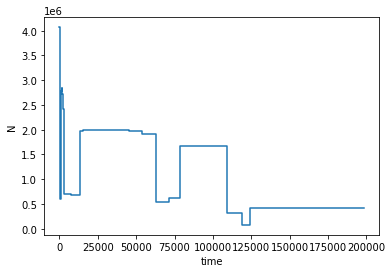

In [25]:
from matplotlib import pyplot as plt

#x[0] are the times, x[1] are the popnsizes
plt.plot(x['time'],x['N'])
plt.xlabel("time")
plt.ylabel("N")

### add demography.py
To add species specific demographic models, we need to add a file called `demographic_models.py` into our species directory.
We can go look at the Arabidopsis demographic model entries for some simple
population size change histories. We can find them at `stdpopsim/catalog/AraTha/demographic_models.py`

For `AnoGam` I'll create an analogous file called
`stdpopsim/catalog/AnoGam/demographic_models.py`
with the following header.

In [ ]:
import msprime
import numpy as np
import stdpopsim

_species = stdpopsim.get_species("AnoGam")

then into here I will add individual models. The model above could be entered as the following

In [ ]:
def _GAS_sp():
    # the size during the interval times[k] to times[k+1] = sizes[k]
    times = np.array(
      [1.08221472e+01, 1.08221472e+01, 1.77815418e+01, 1.77815418e+01,
       2.43957877e+01, 2.43957877e+01, 2.62194838e+01, 2.62194838e+01,
       2.80715527e+01, 2.80715527e+01, 2.99059882e+01, 2.99059882e+01,
       3.17590591e+01, 3.17590591e+01, 3.36213534e+01, 3.36213534e+01,
       3.55031410e+01, 3.55031410e+01, 3.74218265e+01, 3.74218265e+01,
       3.93692837e+01, 3.93692837e+01, 4.13556900e+01, 4.13556900e+01,
       4.33822257e+01, 4.33822257e+01, 4.54501193e+01, 4.54501193e+01,
       4.75606499e+01, 4.75606499e+01, 4.97151498e+01, 4.97151498e+01,
       5.19150077e+01, 5.19150077e+01, 5.41616710e+01, 5.41616710e+01,
       5.64566497e+01, 5.64566497e+01, 5.88015192e+01, 5.88015192e+01,
       6.11979243e+01, 6.11979243e+01, 6.36475829e+01, 6.36475829e+01,
       6.61522900e+01, 6.61522900e+01, 6.87139222e+01, 6.87139222e+01,
       7.13468519e+01, 7.13468519e+01, 7.40546632e+01, 7.40546632e+01,
       7.69788992e+01, 7.69788992e+01, 8.00932536e+01, 8.00932536e+01,
       8.33883683e+01, 8.33883683e+01, 9.33624771e+01, 9.33624771e+01,
       1.05867180e+02, 1.05867180e+02, 1.19778311e+02, 1.19778311e+02,
       1.34317538e+02, 1.34317538e+02, 1.49486416e+02, 1.49486416e+02,
       1.65081438e+02, 1.65081438e+02, 1.81069660e+02, 1.81069660e+02,
       1.96884420e+02, 1.96884420e+02, 2.13010501e+02, 2.13010501e+02,
       2.28659684e+02, 2.28659684e+02, 2.43883726e+02, 2.43883726e+02,
       2.58403062e+02, 2.58403062e+02, 2.70573820e+02, 2.70573820e+02,
       2.75664382e+02, 2.75664382e+02, 2.80730912e+02, 2.80730912e+02,
       2.85888999e+02, 2.85888999e+02, 2.91187697e+02, 2.91187697e+02,
       2.96632655e+02, 2.96632655e+02, 3.02218199e+02, 3.02218199e+02,
       3.07951917e+02, 3.07951917e+02, 3.13860240e+02, 3.13860240e+02,
       3.19955507e+02, 3.19955507e+02, 3.26244790e+02, 3.26244790e+02,
       3.32745865e+02, 3.32745865e+02, 3.39465956e+02, 3.39465956e+02,
       3.46421839e+02, 3.46421839e+02, 3.53626147e+02, 3.53626147e+02,
       3.61092430e+02, 3.61092430e+02, 3.68835241e+02, 3.68835241e+02,
       3.76870235e+02, 3.76870235e+02, 3.85214266e+02, 3.85214266e+02,
       3.93885515e+02, 3.93885515e+02, 4.02903613e+02, 4.02903613e+02,
       4.12289797e+02, 4.12289797e+02, 4.22067072e+02, 4.22067072e+02,
       4.32260401e+02, 4.32260401e+02, 4.42896919e+02, 4.42896919e+02,
       4.54006170e+02, 4.54006170e+02, 4.65620388e+02, 4.65620388e+02,
       4.77774801e+02, 4.77774801e+02, 4.90490498e+02, 4.90490498e+02,
       5.03826473e+02, 5.03826473e+02, 5.17829247e+02, 5.17829247e+02,
       5.32550112e+02, 5.32550112e+02, 5.48045759e+02, 5.48045759e+02,
       5.64379009e+02, 5.64379009e+02, 5.81588679e+02, 5.81588679e+02,
       5.99781759e+02, 5.99781759e+02, 6.19045020e+02, 6.19045020e+02,
       6.39454764e+02, 6.39454764e+02, 6.61129552e+02, 6.61129552e+02,
       6.84129309e+02, 6.84129309e+02, 7.08609246e+02, 7.08609246e+02,
       7.34719738e+02, 7.34719738e+02, 7.62657505e+02, 7.62657505e+02,
       7.92661043e+02, 7.92661043e+02, 8.24963147e+02, 8.24963147e+02,
       8.59801339e+02, 8.59801339e+02, 8.97519058e+02, 8.97519058e+02,
       9.38516578e+02, 9.38516578e+02, 9.83196252e+02, 9.83196252e+02,
       1.03213113e+03, 1.03213113e+03, 1.08595950e+03, 1.08595950e+03,
       1.14545402e+03, 1.14545402e+03, 1.21187638e+03, 1.21187638e+03,
       1.42580467e+03, 1.42580467e+03, 1.66762718e+03, 1.66762718e+03,
       1.94206662e+03, 1.94206662e+03, 2.25673855e+03, 2.25673855e+03,
       2.61982155e+03, 2.61982155e+03, 3.04325043e+03, 3.04325043e+03,
       3.54366638e+03, 3.54366638e+03, 4.14416552e+03, 4.14416552e+03,
       4.86878040e+03, 4.86878040e+03, 5.74277111e+03, 5.74277111e+03,
       6.06376420e+03, 6.06376420e+03, 6.48115044e+03, 6.48115044e+03,
       7.16974182e+03, 7.16974182e+03, 9.94668728e+03, 9.94668728e+03,
       1.08341379e+04, 1.08341379e+04, 1.12602248e+04, 1.12602248e+04,
       1.80292683e+04])
    sizes = np.array([4069863.26413754, 2570469.78880419, 2570469.78880419,
       2398970.46335773, 2398970.46335773,  649423.64089016,
        649423.64089016,  647425.87204344,  647425.87204344,
        629386.55333025,  629386.55333025,  623896.55036331,
        623896.55036331,  615171.6634657 ,  615171.6634657 ,
        609770.71698915,  609770.71698915,  609770.71698915,
        609770.71698915,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  606896.78477367,
        606896.78477367,  606896.78477367,  609770.71698915,
        609770.71698915,  612860.29930411,  612860.29930411,
        646628.97921259,  646628.97921259,  672653.84034255,
        672653.84034255,  694949.57011815,  694949.57011815,
       2053484.48904133, 2053484.48904133, 2512451.15337624,
       2512451.15337624, 2726859.95574373, 2726859.95574373,
       2779609.28386339, 2779609.28386339, 2827486.59107239,
       2827486.59107239, 2833326.90480091, 2833326.90480091,
       2830283.03259496, 2830283.03259496, 2726859.95574373,
       2726859.95574373, 2707367.42825967, 2707367.42825967,
       2557240.92209016, 2557240.92209016, 2420531.19687943,
       2420531.19687943, 2245241.1128414 , 2245241.1128414 ,
       1829782.22978925, 1829782.22978925,  743769.25832605,
        743769.25832605,  719107.79112942,  719107.79112942,
        710882.47527273,  710882.47527273,  708782.9061541 ,
        708782.9061541 ,  706605.83914068,  706605.83914068,
        702884.83678823,  702884.83678823,  699330.14877435,
        699330.14877435,  698106.79217618,  698106.79217618,
        697332.03584512,  697332.03584512,  696317.93467906,
        696317.93467906,  696167.64460966,  696167.64460966,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  695633.55941906,
        695633.55941906,  695633.55941906,  694677.60526595,
        694677.60526595,  694677.60526595,  694677.60526595,
        694677.60526595,  694677.60526595,  694677.60526595,
        694677.60526595,  694677.60526595,  694677.60526595,
        694677.60526595,  694677.60526595,  693429.24269629,
        693429.24269629,  693429.24269629,  693429.24269629,
        693429.24269629,  693429.24269629,  692716.93526192,
        692716.93526192,  692379.41939462,  692379.41939462,
        690176.6983718 ,  690176.6983718 ,  688681.83478372,
        688681.83478372,  687162.86783629,  687162.86783629,
        686235.36369922,  686235.36369922,  686150.90910499,
        686150.90910499,  685951.34145025,  685951.34145025,
        685005.95081601,  685005.95081601,  684576.59330447,
        684576.59330447,  684576.59330447,  684576.59330447,
        683889.43627665,  683889.43627665,  683889.43627665,
        683889.43627665,  683889.43627665,  683889.43627665,
        683889.43627665,  683889.43627665,  687172.58638815,
        687172.58638815, 1980227.21562606, 1980227.21562606,
       1989715.58702617, 1989715.58702617, 1992430.35210815,
       1992430.35210815, 1998953.44050118, 1998953.44050118,
       1998953.44050118, 1998953.44050118, 1998160.88128216,
       1998160.88128216, 1998160.88128216, 1998160.88128216,
       1998160.88128216, 1998160.88128216, 1972764.03439268,
       1972764.03439268, 1903551.76041575, 1903551.76041575,
        543762.2932594 ,  543762.2932594 ,  530289.21416049,
        530289.21416049,  624896.67937685,  624896.67937685,
       1680052.006021  , 1680052.006021  ,  322144.56539297,
        322144.56539297,   77334.77862527,   77334.77862527,
        409527.12801416,  409527.12801416]
        )

    demographic_events = []
    for sz, t in zip(sizes, times):
        demographic_events.append(
            msprime.PopulationParametersChange(time=t, initial_size=sz, population_id=0)
        )
    populations = [
        stdpopsim.Population(
            id="GAS",
            description="Gabon gabiae population",
            )
        ]

    return stdpopsim.DemographicModel(
        id="GAS_1A17",
        description="Stairwayplot estimates of N(t) for Gabon sample",
        long_description="""
        These estimates were done as part of the Ag1000G 2017 Consortium
        paper. Stairwayplot was run with the addition of a misorientation
        parameter using SFS information from each population. 
        """,
        populations=populations,
        citations=[
            stdpopsim.Citation(
            doi="https://doi.org/10.1038/nature24995",
            year=2017,
            author="Ag1000G Consortium",
            reasons={stdpopsim.CiteReason.DEM_MODEL},
            )
        ],
        generation_time=1/11,
        demographic_events=demographic_events,
        population_configurations=[
            msprime.PopulationConfiguration(
                initial_size=4069863, metadata=populations[0].asdict()
            )
        ],
    )

_species.add_demographic_model(_GAS_sp())

the last touch is to add the following line to the `AnoGam/__init__.py` file
```
from . import demographic_models  # noqa: F401
```

then to make sure it works we can run it on the command line with
```
python -m stdpopsim AnoGam --help-models
```
or we can just go ahead and really run a simulation
```
python -m stdpopsim AnoGam 2 -c 2L -l 0.1 -o 2l.tree
Simulation information:
    Engine: msprime (1.0.0a6)
    Model id: PiecewiseConstant
    Model desciption: Piecewise constant size population model over multiple epochs.
    Population: number_samples (sampling_time_generations):
        0: 2 (None)
Contig Description:
    Contig length: 4936432.0
    Mean recombination rate: 0.0
    Mean mutation rate: 5.49e-09
    Genetic map: None

If you use this simulation in published work, please cite:
[stdpopsim]
Adrion et al., 2020: https://doi.org/10.7554/eLife.54967
[simulation engine]
Kelleher et al., 2016: https://doi.org/10.1371/journal.pcbi.1004842
[mutation rate]
Ag1000G Consortium, 2017: https://doi.org/10.1038/nature24995
[genome assembly]
Sharakhova et al., 2006: https://doi.org/10.1186/gb-2007-8-1-r5
[recombination rate]
Pombi et al., 2015: https://doi.org/10.4269/ajtmh.2006.75.901
```

### Github workflow redux
So once again now that our code is ready to share with others, we will 
start a Pull Request on Github that adds the new demographic model. To do so
I'm assuming you're already on a topic branch, so we'll go through the same steps 
as above
```
git checkout -b mossie_hist
git add stdpopsim/catalog/AnoGam/demographic_models.py
git status
```
look ok?
```
git commit -am "added new demographic model to AnoGam"
git push --set-upstream origin mossie_hist 
```
then again you'll navigate to Github to open your PR through the website.

When you open a PR with a new demographic model we ask that you also open a new issue using the Model QC template which will trigger the QC process. You can read further about model QC [here](https://stdpopsim.readthedocs.io/en/latest/development.html#so-the-model-is-implemented-what-next)
![Figure4](gh4.png)